# Analisis Akurasi dan Interpretasi Model XGBoost untuk Pricing Asuransi Kompensasi Pekerja

**By Jonathan Stanley**

Penelitian ini bertujuan untuk mengevaluasi performa dari model XGBoost untuk pricing asuransi kompensasi pekerja. Untuk mendapatkan pemahaman dan pengertian yang lebih lanjut,silahkan dilihat melalui google slides dibawah. https://docs.google.com/presentation/d/1ojoMorsrE_h54eq0wvs4Lm_RFsWJsQzhIRxDrbhbGEM/edit?usp=sharing

In [1]:
!pip install optuna
!pip install scikit-optimize
!pip install xgboost
!pip install bayesian-optimization


  Using cached bayesian_optimization-1.4.3-py3-none-any.whl (18 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
  Attempting uninstall: colorama
    Found existing installation: colorama 0.4.5
    Uninstalling colorama-0.4.5:
      Successfully uninstalled colorama-0.4.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.11.1 requires ruamel-yaml, which is not installed.


In [12]:
#Basic Library
import pandas as pd
import numpy as np
import shap


#Untuk pengolahan data
from sklearn.model_selection import train_test_split, KFold , RepeatedKFold
from sklearn.preprocessing import MinMaxScaler

#Model XGboost dan optimisasi
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.callbacks import EarlyStopper
from skopt.space import Real, Categorical, Integer
from scipy.stats import norm

#Evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, accuracy_score ,roc_auc_score





## A) Data Processing

### Data Reading

In [71]:
file_path = 'train.csv'
df = pd.read_csv(file_path,index_col=0)


In [72]:
#pengubahan tipe fitur DateTime & seleksi data
df['DateTimeOfAccident'] = pd.to_datetime(df['DateTimeOfAccident'])
df['DateReported'] = pd.to_datetime(df['DateReported'])
df['YearReported'] = df['DateReported'].dt.year

#Menggunakan data yang relevan
df = df.loc[(df['YearReported']>=1991)]

df.shape

(45291, 15)

### Data Understanding

In [15]:
# First 5 rows of the dataframe
df.head().T

ClaimNumber,WC8285054,WC6982224,WC5481426,WC9775968,WC6828422
DateTimeOfAccident,2002-04-09 07:00:00+00:00,1999-01-07 11:00:00+00:00,1996-03-25 00:00:00+00:00,2005-06-22 13:00:00+00:00,1999-06-21 11:00:00+00:00
DateReported,2002-07-05 00:00:00+00:00,1999-01-20 00:00:00+00:00,1996-04-14 00:00:00+00:00,2005-07-22 00:00:00+00:00,1999-09-09 00:00:00+00:00
Age,48,43,30,41,50
Gender,M,F,M,M,M
MaritalStatus,M,M,U,S,M
DependentChildren,0,0,0,0,0
DependentsOther,0,0,0,0,0
WeeklyWages,500.0,509.34,709.1,555.46,200.0
PartTimeFullTime,F,F,F,F,F
HoursWorkedPerWeek,38.0,37.5,38.0,38.0,38.0


In [16]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 45291 entries, WC8285054 to WC5038565
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   DateTimeOfAccident         45291 non-null  datetime64[ns, UTC]
 1   DateReported               45291 non-null  datetime64[ns, UTC]
 2   Age                        45291 non-null  int64              
 3   Gender                     45291 non-null  object             
 4   MaritalStatus              45263 non-null  object             
 5   DependentChildren          45291 non-null  int64              
 6   DependentsOther            45291 non-null  int64              
 7   WeeklyWages                45291 non-null  float64            
 8   PartTimeFullTime           45291 non-null  object             
 9   HoursWorkedPerWeek         45291 non-null  float64            
 10  DaysWorkedPerWeek          45291 non-null  int64              


(45291, 15)

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,45291.0,34.009207,12.159998,13.000000,24.00000,32.000000,43.000000,81.000
DependentChildren,45291.0,0.079861,0.418868,0.000000,0.00000,0.000000,0.000000,9.000
DependentsOther,45291.0,0.007397,0.090693,0.000000,0.00000,0.000000,0.000000,3.000
WeeklyWages,45291.0,428.014364,260.023794,1.000000,200.00000,412.770000,521.180000,7497.000
HoursWorkedPerWeek,45291.0,37.569711,12.452778,0.000000,38.00000,38.000000,40.000000,640.000
DaysWorkedPerWeek,45291.0,4.894063,0.581220,1.000000,5.00000,5.000000,5.000000,7.000
InitialIncurredCalimsCost,45291.0,8753.829922,22102.047855,1.000000,756.00000,2500.000000,10000.000000,2000000.000
UltimateIncurredClaimCost,45291.0,11947.669219,35420.756715,121.886805,945.02231,3723.166477,9116.191048,4027135.935
YearReported,45291.0,1998.066106,4.352081,1991.000000,1994.00000,1998.000000,2002.000000,2006.000


### Data Preprocessing

Handling Missing Values

In [18]:
# Hitung missing values
df.isnull().sum()

DateTimeOfAccident            0
DateReported                  0
Age                           0
Gender                        0
MaritalStatus                28
DependentChildren             0
DependentsOther               0
WeeklyWages                   0
PartTimeFullTime              0
HoursWorkedPerWeek            0
DaysWorkedPerWeek             0
ClaimDescription              0
InitialIncurredCalimsCost     0
UltimateIncurredClaimCost     0
YearReported                  0
dtype: int64

In [19]:
df[df.isnull().any(axis=1)].T

ClaimNumber,WC3603450,WC3938584,WC9825722,WC4853326,WC3019033,WC7426694,WC3571601,WC3926350,WC8820716,WC4258521,...,WC4125729,WC8409123,WC9017657,WC4600391,WC9746124,WC3163160,WC4597889,WC3975707,WC4830946,WC9834936
DateTimeOfAccident,1992-09-25 14:00:00+00:00,1992-05-07 07:00:00+00:00,2005-07-12 16:00:00+00:00,1994-02-10 22:00:00+00:00,1991-10-21 07:00:00+00:00,2000-10-17 15:00:00+00:00,1992-11-10 12:00:00+00:00,1992-07-10 11:00:00+00:00,2003-07-21 09:00:00+00:00,1993-12-10 17:00:00+00:00,...,1993-03-12 17:00:00+00:00,2002-05-30 13:00:00+00:00,2003-03-21 12:00:00+00:00,1994-02-16 09:00:00+00:00,2005-01-31 09:00:00+00:00,1991-08-21 12:00:00+00:00,1994-03-10 08:00:00+00:00,1993-02-15 13:00:00+00:00,1994-04-11 12:00:00+00:00,2005-01-12 09:00:00+00:00
DateReported,1992-10-09 00:00:00+00:00,1992-05-23 00:00:00+00:00,2005-10-27 00:00:00+00:00,1994-03-02 00:00:00+00:00,1991-10-29 00:00:00+00:00,2000-11-09 00:00:00+00:00,1992-11-26 00:00:00+00:00,1992-09-03 00:00:00+00:00,2003-07-28 00:00:00+00:00,1994-01-17 00:00:00+00:00,...,1993-04-15 00:00:00+00:00,2002-10-23 00:00:00+00:00,2003-05-05 00:00:00+00:00,1994-03-03 00:00:00+00:00,2005-02-16 00:00:00+00:00,1991-08-25 00:00:00+00:00,1994-03-30 00:00:00+00:00,1993-05-12 00:00:00+00:00,1994-10-05 00:00:00+00:00,2005-01-27 00:00:00+00:00
Age,53,58,42,40,33,38,47,45,18,20,...,52,33,22,59,55,36,52,39,32,23
Gender,M,F,M,M,M,M,F,M,F,M,...,F,M,M,M,M,M,M,M,M,M
MaritalStatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DependentChildren,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DependentsOther,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WeeklyWages,465.4,446.52,500.0,702.5,379.63,784.61,466.56,385.6,500.0,543.66,...,672.6,500.0,473.1,644.4,437.87,350.0,637.9,650.0,836.92,500.0
PartTimeFullTime,F,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,F
HoursWorkedPerWeek,38.0,38.0,40.0,42.0,40.0,56.0,40.0,38.0,40.0,40.0,...,33.0,40.0,40.0,38.0,40.0,38.0,38.0,38.0,38.0,40.0


In [20]:
#Analisa column dengan missing value
df.groupby(df['MaritalStatus'])['UltimateIncurredClaimCost'].agg(['mean','median','count'])

,mean,median,count
MaritalStatus,,,
M,13028.654077,4522.489306,18654
S,9857.401085,2486.967424,21926
U,17466.998886,6469.310541,4683


'MartialStatus' memiliki value : (M)arried, (S)ingle, (U)nknown.

In [73]:
# Mengisi missing values dengan status U = Unknown
df['MaritalStatus']= df['MaritalStatus'].fillna('U')

In [74]:
#Mengecek ulang apakah masih ada missing value
df.isna().any().any()

False

Feature Engineering

In [75]:
#pengubahan tipe fitur DateTime

df['DateTimeOfAccident'] = pd.to_numeric(df['DateTimeOfAccident'])
df['DateReported'] = pd.to_numeric(df['DateReported'])

#pemilihan dan rekayasa fitur
df['ReportingDelay'] = (df['DateReported'] - df['DateTimeOfAccident'])
df.drop(columns=['ClaimDescription'], inplace=True)

In [76]:
#penghapusan unknown value

df.dropna(inplace=True)
df = df.loc[(df['Gender'] != 'U')&(df['MaritalStatus'] != 'U')]

In [77]:
#penghapusan data dengan nilai fitur tidak realistis
df = df.loc[(df['HoursWorkedPerWeek'] <= 168)&(df['HoursWorkedPerWeek']>0)&
            (df['ReportingDelay']>=0)]
df.shape

(40525, 15)

Outliers

In [78]:
# Mencari nilai yang ekstrim dari variabel target
vars = ['UltimateIncurredClaimCost']
print(df[vars].sort_values(by='UltimateIncurredClaimCost', ascending=False).head(8))

             UltimateIncurredClaimCost
ClaimNumber                           
WC9916019                 4.027136e+06
WC4540054                 8.657706e+05
WC8981820                 7.684851e+05
WC9789765                 7.414980e+05
WC7286241                 7.137841e+05
WC7977652                 6.086504e+05
WC9540190                 5.869128e+05
WC9879169                 5.584090e+05


In [79]:
#Membatasi outlier dimana data memiliki nilai yang sangat ekstrim
df.loc[df['UltimateIncurredClaimCost'] > 1000000, 'UltimateIncurredClaimCost'] = 1000000. * 1.000


### Data Transformation

In [80]:
#One Hot Encoding 
category = pd.get_dummies(df[['Gender','MaritalStatus','PartTimeFullTime']], 
                          drop_first=True)
#Target variabel
label = df[['UltimateIncurredClaimCost']]

df.drop(columns=['DateReported','Gender','MaritalStatus','PartTimeFullTime',
                 'UltimateIncurredClaimCost','YearReported'], inplace=True)
df = pd.concat([df, category], axis=1)

In [29]:
#normalisasi
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)
df

,DateTimeOfAccident,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,ReportingDelay,Gender_M,MaritalStatus_S,PartTimeFullTime_P
ClaimNumber,,,,,,,,,,,,
WC8285054,0.778189,0.522388,0.0,0.0,0.066569,0.221557,0.666667,0.000750,0.079263,1.0,0.0,0.0
WC6982224,0.584759,0.447761,0.0,0.0,0.067815,0.218563,0.666667,0.002750,0.011236,0.0,0.0,0.0
WC9775968,0.968755,0.417910,0.0,0.0,0.073967,0.221557,0.666667,0.007500,0.026752,1.0,1.0,0.0
WC6828422,0.611628,0.552239,0.0,0.0,0.026547,0.221557,0.666667,0.000250,0.072690,1.0,0.0,0.0
WC8058150,0.734248,0.388060,0.0,0.0,0.026547,0.221557,0.666667,0.000250,0.008484,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
WC7006507,0.616188,0.328358,0.0,0.0,0.026547,0.233533,0.666667,0.007500,0.544141,1.0,0.0,0.0
WC9370727,0.919122,0.283582,0.0,0.0,0.066569,0.221557,0.666667,0.000500,0.015555,0.0,1.0,0.0
WC8396269,0.781296,0.104478,0.0,0.0,0.066569,0.233533,0.666667,0.000500,0.116793,0.0,1.0,0.0


In [30]:
label

,UltimateIncurredClaimCost
ClaimNumber,
WC8285054,4748.203388
WC6982224,6326.285819
WC9775968,17786.487170
WC6828422,598.762315
WC8058150,279.068178
...,...
WC7006507,11847.081780
WC9370727,480.493308
WC8396269,755.735319


In [31]:
df.head().T

ClaimNumber,WC8285054,WC6982224,WC9775968,WC6828422,WC8058150
DateTimeOfAccident,0.778189,0.584759,0.968755,0.611628,0.734248
Age,0.522388,0.447761,0.417910,0.552239,0.388060
DependentChildren,0.000000,0.000000,0.000000,0.000000,0.000000
DependentsOther,0.000000,0.000000,0.000000,0.000000,0.000000
WeeklyWages,0.066569,0.067815,0.073967,0.026547,0.026547
HoursWorkedPerWeek,0.221557,0.218563,0.221557,0.221557,0.221557
DaysWorkedPerWeek,0.666667,0.666667,0.666667,0.666667,0.666667
InitialIncurredCalimsCost,0.000750,0.002750,0.007500,0.000250,0.000250
ReportingDelay,0.079263,0.011236,0.026752,0.072690,0.008484
Gender_M,1.000000,0.000000,1.000000,1.000000,1.000000


In [32]:
df.shape

(40525, 12)

## Data Modelling

### Data Splitting

Data training dan testing akan dibagi dengan perbandingan 70:30, dimana 70% barisan pertama termasuk dalam training set, dan 30% baris terakhir termasuk dalam testing set

In [81]:
X = df
y = label.values


In [34]:
y

array([[ 4748.203388 ],
       [ 6326.285819 ],
       [17786.48717  ],
       ...,
       [  755.7353189],
       [  418.1784607],
       [ 2695.2257   ]])

In [35]:
X

,DateTimeOfAccident,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,ReportingDelay,Gender_M,MaritalStatus_S,PartTimeFullTime_P
ClaimNumber,,,,,,,,,,,,
WC8285054,0.778189,0.522388,0.0,0.0,0.066569,0.221557,0.666667,0.000750,0.079263,1.0,0.0,0.0
WC6982224,0.584759,0.447761,0.0,0.0,0.067815,0.218563,0.666667,0.002750,0.011236,0.0,0.0,0.0
WC9775968,0.968755,0.417910,0.0,0.0,0.073967,0.221557,0.666667,0.007500,0.026752,1.0,1.0,0.0
WC6828422,0.611628,0.552239,0.0,0.0,0.026547,0.221557,0.666667,0.000250,0.072690,1.0,0.0,0.0
WC8058150,0.734248,0.388060,0.0,0.0,0.026547,0.221557,0.666667,0.000250,0.008484,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
WC7006507,0.616188,0.328358,0.0,0.0,0.026547,0.233533,0.666667,0.007500,0.544141,1.0,0.0,0.0
WC9370727,0.919122,0.283582,0.0,0.0,0.066569,0.221557,0.666667,0.000500,0.015555,0.0,1.0,0.0
WC8396269,0.781296,0.104478,0.0,0.0,0.066569,0.233533,0.666667,0.000500,0.116793,0.0,1.0,0.0


In [49]:
# Mendefinisikan Jangkauan searching untuk hyperparameter
params = {
    "alpha": Real(0.01, 10, prior='log-uniform'),
    "learning_rate": Real(0.01, 0.5, prior='uniform'),
    "max_depth": Integer(2, 10),
    "n_estimators": Integer(50, 1000),
    "min_child_weight": Real(1, 10),
    "subsample": Real(0.5, 1.0, prior='uniform'),
    "colsample_bytree": Real(0.1, 1.0, prior='uniform'),
    "gamma": Real(0, 10)
}




In [50]:
rmse_scores = []
mae_scores = []
r2_scores = []
coverage_prob_scores = []

max_iteration = 10

for iteration in range(max_iteration):
    print(f"Iteration {iteration+1}")

    # Splitting data training dan testing dengan perbandingan 70:30.
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=iteration)

    # k-fold Cross Validation
    k = 4
    kf = KFold(n_splits=k, shuffle=True, random_state=0)

    rmse_iteration_scores = []
    mae_iteration_scores = []
    r2_iteration_scores = []
    max_depth_iteration_scores = []
    coverage_prob_iteration_scores = []
    var_iteration_scores = []

    for train_index, val_index in kf.split(X_train_full):
        X_train, X_val = np.array(X_train_full)[train_index], np.array(X_train_full)[val_index]
        y_train, y_val = np.array(y_train_full)[train_index], np.array(y_train_full)[val_index]

        # Objective Function yang terdefnisi dalam loop
        def objective_function(alpha, learning_rate, max_depth, n_estimators, min_child_weight, subsample,
                               colsample_bytree, gamma):
            model = xgb.XGBRegressor(
                alpha=alpha,
                learning_rate=learning_rate,
                max_depth=int(max_depth),
                n_estimators=int(n_estimators),
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                gamma=gamma
            )

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            return -mean_squared_error(y_val, y_pred)

        # Bayes Search
        bayes_opt = BayesSearchCV(
            xgb.XGBRegressor(),
            params,
            n_iter=50,
            cv=kf,
            scoring='neg_mean_squared_error',
            random_state=0,
            verbose=0,
            fit_params={
                'eval_set': [(X_val, y_val)],
                'early_stopping_rounds': 10,
                'verbose': 1
            }
        )

        bayes_opt.fit(X_train, y_train)
        best_params = bayes_opt.best_params_

        # Pelatihan Model XGBoost dengan parameter terbaik
        model = xgb.XGBRegressor(
            alpha=best_params['alpha'],
            learning_rate=best_params['learning_rate'],
            max_depth=best_params['max_depth'],
            n_estimators=best_params['n_estimators'],
            min_child_weight=best_params['min_child_weight'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            gamma=best_params['gamma']
        )
        # Fitting model dengan data training dan evaluation set
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=10,
                  verbose=1)

        y_pred = model.predict(X_test)

        # Metrik Evaluasi Umum
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    

        # Variabel untuk menghitung Coverage probability dan VaR
        alpha = 0.05  
        residuals = y_test - y_pred
        std_residuals = residuals / np.std(residuals)
        
        # Metrik Coverage Probability
        coverage_prob = np.mean((std_residuals > norm.ppf(alpha / 2)) & (std_residuals < norm.ppf(1 - alpha / 2)))


        # Append metrik evaluasi
        rmse_iteration_scores.append(rmse)
        mae_iteration_scores.append(mae)
        r2_iteration_scores.append(r2)
        coverage_prob_iteration_scores.append(coverage_prob)


    # Average metrik untuk setiap iterasi
    best_rmse = np.mean(rmse_iteration_scores)
    best_mae = np.mean(mae_iteration_scores)
    best_r2 = np.mean(r2_iteration_scores)
    best_coverage_prob = np.mean(coverage_prob_iteration_scores)


    # Print best metrik untuk setiap iterasi
    print(f"Best RMSE for iteration {iteration+1}: {best_rmse}")
    print(f"Best MAE for iteration {iteration+1}: {best_mae}")
    print(f"Best R-squared for iteration {iteration+1}: {best_r2}")
    print(f"Best Maximum Depth for iteration {iteration+1}: {best_max_depth}")
    print(f"Average Coverage Probability for iteration {iteration+1}: {best_coverage_prob}")
    print(f"Average VaR for iteration {iteration+1}: {best_var}")

    # Append nilai metrik setiap iterasi ke sebuah list
    best_rmse_scores.append(best_rmse)
    best_mae_scores.append(best_mae)
    best_r2_scores.append(best_r2)
    best_max_depth_scores.append(best_max_depth)
    coverage_prob_scores.append(best_coverage_prob)
    var_scores.append(best_var)

# Calculate overall average metrics
avg_rmse = np.mean(best_rmse_scores)
avg_mae = np.mean(best_mae_scores)
avg_r2 = np.mean(best_r2_scores)
avg_max_depth = np.mean(best_max_depth_scores)
avg_coverage_prob = np.mean(coverage_prob_scores)
avg_var = np.mean(var_scores)

# Print overall average metrics
print(f"\nOverall Average RMSE: {avg_rmse}")
print(f"Overall Average MAE: {avg_mae}")
print(f"Overall Average R-squared: {avg_r2}")
print(f"Overall Average Maximum Depth: {avg_max_depth}")
print(f"Overall Average Coverage Probability: {avg_coverage_prob}")
print(f"Overall Average VaR: {avg_var}")

        
        
        


Iteration 1
[0]	validation_0-rmse:31952.13170
[1]	validation_0-rmse:31661.14264
[2]	validation_0-rmse:31418.51884
[3]	validation_0-rmse:30585.42418
[4]	validation_0-rmse:29855.18977
[5]	validation_0-rmse:29226.59767
[6]	validation_0-rmse:28684.65021
[7]	validation_0-rmse:28526.38713
[8]	validation_0-rmse:28424.37986
[9]	validation_0-rmse:28297.72916
[10]	validation_0-rmse:27834.51341
[11]	validation_0-rmse:27719.13816
[12]	validation_0-rmse:27350.07748
[13]	validation_0-rmse:27061.99498
[14]	validation_0-rmse:26793.11528
[15]	validation_0-rmse:26548.04985
[16]	validation_0-rmse:26302.10678
[17]	validation_0-rmse:26272.81157
[18]	validation_0-rmse:26111.71541
[19]	validation_0-rmse:25949.73710
[20]	validation_0-rmse:25812.47305
[21]	validation_0-rmse:25790.09716
[22]	validation_0-rmse:25684.54250
[23]	validation_0-rmse:25597.94405
[24]	validation_0-rmse:25580.78310
[25]	validation_0-rmse:25504.43632


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-rmse:25494.87681
[27]	validation_0-rmse:25480.03600
[28]	validation_0-rmse:25474.08725
[29]	validation_0-rmse:25468.74627
[30]	validation_0-rmse:25409.58863
[31]	validation_0-rmse:25401.72922
[32]	validation_0-rmse:25339.19995
[33]	validation_0-rmse:25295.89715
[34]	validation_0-rmse:25244.34900
[35]	validation_0-rmse:25215.25259
[36]	validation_0-rmse:25214.64676
[37]	validation_0-rmse:25216.14806
[38]	validation_0-rmse:25187.55315
[39]	validation_0-rmse:25182.69189
[40]	validation_0-rmse:25178.69855
[41]	validation_0-rmse:25152.90656
[42]	validation_0-rmse:25152.40845
[43]	validation_0-rmse:25154.46012
[44]	validation_0-rmse:25152.92106
[45]	validation_0-rmse:25153.47396
[46]	validation_0-rmse:25153.15761
[47]	validation_0-rmse:25154.88193
[48]	validation_0-rmse:25137.84880
[49]	validation_0-rmse:25116.91747
[50]	validation_0-rmse:25108.00375
[51]	validation_0-rmse:25107.46199
[52]	validation_0-rmse:25107.16131
[53]	validation_0-rmse:25111.43035
[54]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:25837.79907
[29]	validation_0-rmse:25723.44401
[30]	validation_0-rmse:25620.19288
[31]	validation_0-rmse:25585.30128
[32]	validation_0-rmse:25485.64049
[33]	validation_0-rmse:25386.54104
[34]	validation_0-rmse:25292.39810
[35]	validation_0-rmse:25200.56224
[36]	validation_0-rmse:25178.58429
[37]	validation_0-rmse:25156.31463
[38]	validation_0-rmse:25076.39751
[39]	validation_0-rmse:25052.94859
[40]	validation_0-rmse:25033.51152
[41]	validation_0-rmse:24963.33946
[42]	validation_0-rmse:24948.03102
[43]	validation_0-rmse:24930.15967
[44]	validation_0-rmse:24914.18730
[45]	validation_0-rmse:24894.47153
[46]	validation_0-rmse:24828.87637
[47]	validation_0-rmse:24762.57060
[48]	validation_0-rmse:24702.98816
[49]	validation_0-rmse:24645.71774
[50]	validation_0-rmse:24580.51980
[51]	validation_0-rmse:24570.48168
[52]	validation_0-rmse:24556.67714
[53]	validation_0-rmse:24544.82692
[54]	validation_0-rmse:24486.98529
[55]	validation_0-rmse:24476.48067
[56]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-rmse:22736.51166
[23]	validation_0-rmse:22669.41219
[24]	validation_0-rmse:22605.44473
[25]	validation_0-rmse:22548.81631
[26]	validation_0-rmse:22504.96888
[27]	validation_0-rmse:22478.97504
[28]	validation_0-rmse:22433.25954
[29]	validation_0-rmse:22391.15173
[30]	validation_0-rmse:22356.55833
[31]	validation_0-rmse:22320.91409
[32]	validation_0-rmse:22296.53953
[33]	validation_0-rmse:22269.34952
[34]	validation_0-rmse:22245.12618
[35]	validation_0-rmse:22223.27316
[36]	validation_0-rmse:22204.61640
[37]	validation_0-rmse:22186.01289
[38]	validation_0-rmse:22168.57120
[39]	validation_0-rmse:22153.41074
[40]	validation_0-rmse:22143.87927
[41]	validation_0-rmse:22128.86575
[42]	validation_0-rmse:22120.11445
[43]	validation_0-rmse:22112.72884
[44]	validation_0-rmse:22103.18777
[45]	validation_0-rmse:22095.27222
[46]	validation_0-rmse:22102.98504
[47]	validation_0-rmse:22094.77829
[48]	validation_0-rmse:22090.23125
[49]	validation_0-rmse:22078.72525
[50]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:28768.02495
[25]	validation_0-rmse:28692.11612
[26]	validation_0-rmse:28617.58945
[27]	validation_0-rmse:28544.51855
[28]	validation_0-rmse:28472.55248
[29]	validation_0-rmse:28402.35799
[30]	validation_0-rmse:28332.61564
[31]	validation_0-rmse:28265.26268
[32]	validation_0-rmse:28197.94771
[33]	validation_0-rmse:28131.91243
[34]	validation_0-rmse:28067.02781
[35]	validation_0-rmse:28003.43114
[36]	validation_0-rmse:27941.40325
[37]	validation_0-rmse:27879.87968
[38]	validation_0-rmse:27819.28355
[39]	validation_0-rmse:27759.94923
[40]	validation_0-rmse:27701.52860
[41]	validation_0-rmse:27644.36136
[42]	validation_0-rmse:27588.55184
[43]	validation_0-rmse:27533.27074
[44]	validation_0-rmse:27479.06857
[45]	validation_0-rmse:27425.45260
[46]	validation_0-rmse:27373.27284
[47]	validation_0-rmse:27322.05955
[48]	validation_0-rmse:27271.37323
[49]	validation_0-rmse:27221.87612
[50]	validation_0-rmse:27171.32640
[51]	validation_0-rmse:27123.53743
[52]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:25887.77147
[30]	validation_0-rmse:25858.70975
[31]	validation_0-rmse:25855.46039
[32]	validation_0-rmse:25849.48276
[33]	validation_0-rmse:25841.42128
[34]	validation_0-rmse:25825.55193
[35]	validation_0-rmse:25807.78200
[36]	validation_0-rmse:25794.52018
[37]	validation_0-rmse:25786.10428
[38]	validation_0-rmse:25779.52870
[39]	validation_0-rmse:25761.33424
[40]	validation_0-rmse:25755.06425
[41]	validation_0-rmse:25741.42834
[42]	validation_0-rmse:25725.81518
[43]	validation_0-rmse:25716.77340
[44]	validation_0-rmse:25719.57912
[45]	validation_0-rmse:25711.33790
[46]	validation_0-rmse:25706.00502
[47]	validation_0-rmse:25703.81238
[48]	validation_0-rmse:25708.27921
[49]	validation_0-rmse:25707.68510
[50]	validation_0-rmse:25713.85771
[51]	validation_0-rmse:25714.14266
[52]	validation_0-rmse:25718.98323
[53]	validation_0-rmse:25717.70766
[54]	validation_0-rmse:25714.41740
[55]	validation_0-rmse:25710.65628
[56]	validation_0-rmse:25708.96733
[0]	validation_0-rms

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:27330.63867
[25]	validation_0-rmse:27214.46106
[26]	validation_0-rmse:27167.65551
[27]	validation_0-rmse:27124.06622
[28]	validation_0-rmse:27082.14662
[29]	validation_0-rmse:26971.78612
[30]	validation_0-rmse:26869.06999
[31]	validation_0-rmse:26834.07565
[32]	validation_0-rmse:26737.07497
[33]	validation_0-rmse:26646.15517
[34]	validation_0-rmse:26560.96917
[35]	validation_0-rmse:26480.02688
[36]	validation_0-rmse:26459.96802
[37]	validation_0-rmse:26435.49340
[38]	validation_0-rmse:26358.12215
[39]	validation_0-rmse:26334.34602
[40]	validation_0-rmse:26312.46553
[41]	validation_0-rmse:26242.56277
[42]	validation_0-rmse:26223.73509
[43]	validation_0-rmse:26204.74880
[44]	validation_0-rmse:26188.35929
[45]	validation_0-rmse:26171.47231
[46]	validation_0-rmse:26108.41869
[47]	validation_0-rmse:26048.17822
[48]	validation_0-rmse:25995.49277
[49]	validation_0-rmse:25942.92153
[50]	validation_0-rmse:25894.21181
[51]	validation_0-rmse:25883.55842
[52]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:31317.56387
[30]	validation_0-rmse:31237.95955
[31]	validation_0-rmse:31207.61138
[32]	validation_0-rmse:31128.77810
[33]	validation_0-rmse:31053.43198
[34]	validation_0-rmse:30981.42661
[35]	validation_0-rmse:30910.78608
[36]	validation_0-rmse:30887.15851
[37]	validation_0-rmse:30860.16989
[38]	validation_0-rmse:30787.50965
[39]	validation_0-rmse:30760.37240
[40]	validation_0-rmse:30731.03371
[41]	validation_0-rmse:30665.01167
[42]	validation_0-rmse:30640.71320
[43]	validation_0-rmse:30615.34845
[44]	validation_0-rmse:30590.95519
[45]	validation_0-rmse:30566.46982
[46]	validation_0-rmse:30499.59389
[47]	validation_0-rmse:30473.89722
[48]	validation_0-rmse:30406.58563
[49]	validation_0-rmse:30343.36759
[50]	validation_0-rmse:30281.59741
[51]	validation_0-rmse:30260.55095
[52]	validation_0-rmse:30237.03358
[53]	validation_0-rmse:30215.29265
[54]	validation_0-rmse:30155.67600
[55]	validation_0-rmse:30134.26164
[56]	validation_0-rmse:30111.82415
[57]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-rmse:25145.55926
[19]	validation_0-rmse:25071.65029
[20]	validation_0-rmse:25006.88569
[21]	validation_0-rmse:24965.84081
[22]	validation_0-rmse:24961.38025
[23]	validation_0-rmse:24925.24580
[24]	validation_0-rmse:24920.27022
[25]	validation_0-rmse:24915.53077
[26]	validation_0-rmse:24896.13612
[27]	validation_0-rmse:24894.90876
[28]	validation_0-rmse:24896.80720
[29]	validation_0-rmse:24883.14511
[30]	validation_0-rmse:24878.69369
[31]	validation_0-rmse:24881.89264
[32]	validation_0-rmse:24883.91924
[33]	validation_0-rmse:24882.42253
[34]	validation_0-rmse:24898.07477
[35]	validation_0-rmse:24902.57181
[36]	validation_0-rmse:24903.89909
[37]	validation_0-rmse:24902.74153
[38]	validation_0-rmse:24901.08994
[39]	validation_0-rmse:24888.91653
[40]	validation_0-rmse:24889.16269
Best RMSE for iteration 2: 21866.071384566465
Best MAE for iteration 2: 7312.910484848353
Best R-squared for iteration 2: 0.3512624677290995
Best Maximum Depth for iteration 2: 2.5
Average Covera

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:27192.53233
[29]	validation_0-rmse:27110.58136
[30]	validation_0-rmse:27029.11187
[31]	validation_0-rmse:26994.35172
[32]	validation_0-rmse:26914.79845
[33]	validation_0-rmse:26840.55488
[34]	validation_0-rmse:26761.63454
[35]	validation_0-rmse:26687.54500
[36]	validation_0-rmse:26664.41668
[37]	validation_0-rmse:26636.81961
[38]	validation_0-rmse:26563.20709
[39]	validation_0-rmse:26536.76340
[40]	validation_0-rmse:26507.89221
[41]	validation_0-rmse:26442.24387
[42]	validation_0-rmse:26417.76717
[43]	validation_0-rmse:26393.18363
[44]	validation_0-rmse:26368.96681
[45]	validation_0-rmse:26342.43861
[46]	validation_0-rmse:26274.72071
[47]	validation_0-rmse:26210.30984
[48]	validation_0-rmse:26146.82117
[49]	validation_0-rmse:26081.53963
[50]	validation_0-rmse:26021.31215
[51]	validation_0-rmse:26000.79176
[52]	validation_0-rmse:25977.84212
[53]	validation_0-rmse:25956.67510
[54]	validation_0-rmse:25892.90745
[55]	validation_0-rmse:25871.70316
[56]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-rmse:26367.17984
[24]	validation_0-rmse:26222.10926
[25]	validation_0-rmse:26076.96651
[26]	validation_0-rmse:26026.66767
[27]	validation_0-rmse:25978.25557
[28]	validation_0-rmse:25931.88245
[29]	validation_0-rmse:25893.73287
[30]	validation_0-rmse:25764.62562
[31]	validation_0-rmse:25727.48359
[32]	validation_0-rmse:25617.93230
[33]	validation_0-rmse:25514.05236
[34]	validation_0-rmse:25414.62985
[35]	validation_0-rmse:25307.66758
[36]	validation_0-rmse:25283.87910
[37]	validation_0-rmse:25255.61303
[38]	validation_0-rmse:25164.60958
[39]	validation_0-rmse:25136.16560
[40]	validation_0-rmse:25106.81149
[41]	validation_0-rmse:25019.19340
[42]	validation_0-rmse:24994.98346
[43]	validation_0-rmse:24973.22296
[44]	validation_0-rmse:24954.01675
[45]	validation_0-rmse:24935.72061
[46]	validation_0-rmse:24844.79049
[47]	validation_0-rmse:24775.78399
[48]	validation_0-rmse:24699.40220
[49]	validation_0-rmse:24626.56916
[50]	validation_0-rmse:24557.08560
[51]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:30181.75352
[29]	validation_0-rmse:30150.70180
[30]	validation_0-rmse:30065.37580
[31]	validation_0-rmse:30036.25810
[32]	validation_0-rmse:29959.35822
[33]	validation_0-rmse:29881.02429
[34]	validation_0-rmse:29807.59043
[35]	validation_0-rmse:29736.04390
[36]	validation_0-rmse:29710.61001
[37]	validation_0-rmse:29682.55050
[38]	validation_0-rmse:29613.51995
[39]	validation_0-rmse:29585.38067
[40]	validation_0-rmse:29557.12671
[41]	validation_0-rmse:29486.26251
[42]	validation_0-rmse:29460.94002
[43]	validation_0-rmse:29436.45408
[44]	validation_0-rmse:29412.69328
[45]	validation_0-rmse:29386.64240
[46]	validation_0-rmse:29320.96897
[47]	validation_0-rmse:29253.84698
[48]	validation_0-rmse:29188.19891
[49]	validation_0-rmse:29125.02096
[50]	validation_0-rmse:29065.07879
[51]	validation_0-rmse:29043.76102
[52]	validation_0-rmse:29020.82260
[53]	validation_0-rmse:28998.07785
[54]	validation_0-rmse:28937.83410
[55]	validation_0-rmse:28916.78605
[56]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:29034.48951
[30]	validation_0-rmse:28999.85640
[31]	validation_0-rmse:28853.92646
[32]	validation_0-rmse:28732.17403
[33]	validation_0-rmse:28609.72108
[34]	validation_0-rmse:28594.46189
[35]	validation_0-rmse:28571.16835
[36]	validation_0-rmse:28465.60935
[37]	validation_0-rmse:28447.31787
[38]	validation_0-rmse:28347.64964
[39]	validation_0-rmse:28325.00412
[40]	validation_0-rmse:28304.44181
[41]	validation_0-rmse:28208.76640
[42]	validation_0-rmse:28135.71053
[43]	validation_0-rmse:28121.62281
[44]	validation_0-rmse:28035.67097
[45]	validation_0-rmse:27955.70349
[46]	validation_0-rmse:27940.24063
[47]	validation_0-rmse:27933.74588
[48]	validation_0-rmse:27925.66423
[49]	validation_0-rmse:27853.61264
[50]	validation_0-rmse:27793.60116
[51]	validation_0-rmse:27786.77787
[52]	validation_0-rmse:27776.84959
[53]	validation_0-rmse:27718.74543
[54]	validation_0-rmse:27712.14983
[55]	validation_0-rmse:27702.35101
[56]	validation_0-rmse:27640.22131
[57]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:29160.44838
[25]	validation_0-rmse:29111.85663
[26]	validation_0-rmse:29000.10913
[27]	validation_0-rmse:28955.03163
[28]	validation_0-rmse:28849.68443
[29]	validation_0-rmse:28747.97206
[30]	validation_0-rmse:28650.27199
[31]	validation_0-rmse:28558.13851
[32]	validation_0-rmse:28469.12520
[33]	validation_0-rmse:28433.97843
[34]	validation_0-rmse:28348.13750
[35]	validation_0-rmse:28266.48785
[36]	validation_0-rmse:28187.92848
[37]	validation_0-rmse:28112.22931
[38]	validation_0-rmse:28039.39507
[39]	validation_0-rmse:27969.86460
[40]	validation_0-rmse:27904.98690
[41]	validation_0-rmse:27878.28772
[42]	validation_0-rmse:27815.48848
[43]	validation_0-rmse:27757.31635
[44]	validation_0-rmse:27697.00288
[45]	validation_0-rmse:27639.83150
[46]	validation_0-rmse:27588.22353
[47]	validation_0-rmse:27535.03778
[48]	validation_0-rmse:27482.85369
[49]	validation_0-rmse:27433.78442
[50]	validation_0-rmse:27386.14859
[51]	validation_0-rmse:27342.67938
[52]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:27016.00949
[30]	validation_0-rmse:26912.10493
[31]	validation_0-rmse:26875.88504
[32]	validation_0-rmse:26783.39090
[33]	validation_0-rmse:26688.45454
[34]	validation_0-rmse:26596.61463
[35]	validation_0-rmse:26506.92147
[36]	validation_0-rmse:26422.73877
[37]	validation_0-rmse:26337.23249
[38]	validation_0-rmse:26254.67698
[39]	validation_0-rmse:26228.37457
[40]	validation_0-rmse:26198.20886
[41]	validation_0-rmse:26126.51262
[42]	validation_0-rmse:26099.78529
[43]	validation_0-rmse:26035.75426
[44]	validation_0-rmse:25963.80396
[45]	validation_0-rmse:25886.49272
[46]	validation_0-rmse:25819.14160
[47]	validation_0-rmse:25765.14601
[48]	validation_0-rmse:25705.15592
[49]	validation_0-rmse:25634.88928
[50]	validation_0-rmse:25576.39827
[51]	validation_0-rmse:25556.31386
[52]	validation_0-rmse:25536.58072
[53]	validation_0-rmse:25477.05759
[54]	validation_0-rmse:25420.95386
[55]	validation_0-rmse:25404.30865
[56]	validation_0-rmse:25355.19631
[57]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-rmse:25051.18585
[28]	validation_0-rmse:25005.47392
[29]	validation_0-rmse:24967.49515
[30]	validation_0-rmse:24851.57761
[31]	validation_0-rmse:24815.63371
[32]	validation_0-rmse:24714.19521
[33]	validation_0-rmse:24608.88588
[34]	validation_0-rmse:24504.89881
[35]	validation_0-rmse:24412.90787
[36]	validation_0-rmse:24388.52635
[37]	validation_0-rmse:24358.47156
[38]	validation_0-rmse:24270.98895
[39]	validation_0-rmse:24240.46309
[40]	validation_0-rmse:24210.99015
[41]	validation_0-rmse:24123.38088
[42]	validation_0-rmse:24099.66465
[43]	validation_0-rmse:24078.96435
[44]	validation_0-rmse:24055.50208
[45]	validation_0-rmse:24031.75031
[46]	validation_0-rmse:23962.78724
[47]	validation_0-rmse:23900.24298
[48]	validation_0-rmse:23832.89880
[49]	validation_0-rmse:23762.34693
[50]	validation_0-rmse:23694.14423
[51]	validation_0-rmse:23678.26053
[52]	validation_0-rmse:23657.10278
[53]	validation_0-rmse:23637.55797
[54]	validation_0-rmse:23583.26378
[55]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-rmse:26588.78112
[36]	validation_0-rmse:26575.59662
[37]	validation_0-rmse:26568.36278
[38]	validation_0-rmse:26565.76322
[39]	validation_0-rmse:26559.58671
[40]	validation_0-rmse:26484.82248
[41]	validation_0-rmse:26480.19575
[42]	validation_0-rmse:26478.99730
[43]	validation_0-rmse:26476.62975
[44]	validation_0-rmse:26412.22126
[45]	validation_0-rmse:26347.55866
[46]	validation_0-rmse:26285.77691
[47]	validation_0-rmse:26284.86325
[48]	validation_0-rmse:26230.49922
[49]	validation_0-rmse:26183.58681
[50]	validation_0-rmse:26142.43209
[51]	validation_0-rmse:26111.43717
[52]	validation_0-rmse:26110.21386
[53]	validation_0-rmse:26070.76906
[54]	validation_0-rmse:26036.54247
[55]	validation_0-rmse:26035.85823
[56]	validation_0-rmse:26009.59339
[57]	validation_0-rmse:26009.62771
[58]	validation_0-rmse:25980.23600
[59]	validation_0-rmse:25980.37538
[60]	validation_0-rmse:25958.08092
[61]	validation_0-rmse:25957.93348
[62]	validation_0-rmse:25956.94598
[63]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-rmse:27322.06824
[24]	validation_0-rmse:27209.68892
[25]	validation_0-rmse:27112.45045
[26]	validation_0-rmse:27008.81647
[27]	validation_0-rmse:26924.82370
[28]	validation_0-rmse:26839.53490
[29]	validation_0-rmse:26750.99932
[30]	validation_0-rmse:26670.93477
[31]	validation_0-rmse:26592.84909
[32]	validation_0-rmse:26527.31889
[33]	validation_0-rmse:26460.45013
[34]	validation_0-rmse:26398.31083
[35]	validation_0-rmse:26336.37129
[36]	validation_0-rmse:26280.28002
[37]	validation_0-rmse:26225.64894
[38]	validation_0-rmse:26169.22270
[39]	validation_0-rmse:26125.06797
[40]	validation_0-rmse:26075.54304
[41]	validation_0-rmse:26032.76330
[42]	validation_0-rmse:25989.48466
[43]	validation_0-rmse:25957.00578
[44]	validation_0-rmse:25926.86092
[45]	validation_0-rmse:25889.18762
[46]	validation_0-rmse:25862.62478
[47]	validation_0-rmse:25820.80334
[48]	validation_0-rmse:25790.20763
[49]	validation_0-rmse:25761.88937
[50]	validation_0-rmse:25728.61764
[51]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:28340.47163
[32]	validation_0-rmse:28303.90905
[33]	validation_0-rmse:28187.75753
[34]	validation_0-rmse:28159.87905
[35]	validation_0-rmse:28056.01259
[36]	validation_0-rmse:28032.66940
[37]	validation_0-rmse:28011.93517
[38]	validation_0-rmse:27903.73796
[39]	validation_0-rmse:27884.87243
[40]	validation_0-rmse:27856.69836
[41]	validation_0-rmse:27753.16968
[42]	validation_0-rmse:27731.78645
[43]	validation_0-rmse:27707.02862
[44]	validation_0-rmse:27689.80755
[45]	validation_0-rmse:27671.99499
[46]	validation_0-rmse:27574.67825
[47]	validation_0-rmse:27548.66749
[48]	validation_0-rmse:27456.45548
[49]	validation_0-rmse:27373.95229
[50]	validation_0-rmse:27288.18270
[51]	validation_0-rmse:27271.28805
[52]	validation_0-rmse:27254.18002
[53]	validation_0-rmse:27238.22508
[54]	validation_0-rmse:27228.21659
[55]	validation_0-rmse:27212.41478
[56]	validation_0-rmse:27195.32759
[57]	validation_0-rmse:27182.04768
[58]	validation_0-rmse:27168.78323
[59]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:28624.82008
[34]	validation_0-rmse:28520.59791
[35]	validation_0-rmse:28485.92248
[36]	validation_0-rmse:28387.16335
[37]	validation_0-rmse:28357.14415
[38]	validation_0-rmse:28335.49771
[39]	validation_0-rmse:28244.32131
[40]	validation_0-rmse:28154.78410
[41]	validation_0-rmse:28130.88028
[42]	validation_0-rmse:28045.87436
[43]	validation_0-rmse:27963.91556
[44]	validation_0-rmse:27886.27450
[45]	validation_0-rmse:27809.68808
[46]	validation_0-rmse:27736.51884
[47]	validation_0-rmse:27718.52451
[48]	validation_0-rmse:27644.43406
[49]	validation_0-rmse:27578.15501
[50]	validation_0-rmse:27513.90339
[51]	validation_0-rmse:27450.94497
[52]	validation_0-rmse:27432.94289
[53]	validation_0-rmse:27369.95566
[54]	validation_0-rmse:27312.82139
[55]	validation_0-rmse:27296.95472
[56]	validation_0-rmse:27243.70942
[57]	validation_0-rmse:27229.14063
[58]	validation_0-rmse:27177.47886
[59]	validation_0-rmse:27163.50329
[60]	validation_0-rmse:27115.11427
[61]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:24844.79557
[32]	validation_0-rmse:24847.67222
[33]	validation_0-rmse:24845.79503
[34]	validation_0-rmse:24845.90541
[35]	validation_0-rmse:24862.40224
[36]	validation_0-rmse:24779.44335
[37]	validation_0-rmse:24777.44750
[38]	validation_0-rmse:24716.55510
[39]	validation_0-rmse:24723.69458
[40]	validation_0-rmse:24719.48265
[41]	validation_0-rmse:24721.37758
[42]	validation_0-rmse:24695.57440
[43]	validation_0-rmse:24710.43283
[44]	validation_0-rmse:24694.02057
[45]	validation_0-rmse:24680.03468
[46]	validation_0-rmse:24683.91766
[47]	validation_0-rmse:24682.15638
[48]	validation_0-rmse:24699.18780
[49]	validation_0-rmse:24698.61746
[50]	validation_0-rmse:24713.41107
[51]	validation_0-rmse:24715.17890
[52]	validation_0-rmse:24718.43457
[53]	validation_0-rmse:24742.57827
[54]	validation_0-rmse:24753.15640
[55]	validation_0-rmse:24752.56384
Best RMSE for iteration 5: 23001.9515833211
Best MAE for iteration 5: 7517.913752977127
Best R-squared for iteration 5: 0.330

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:24889.12203
[30]	validation_0-rmse:24780.46215
[31]	validation_0-rmse:24742.77524
[32]	validation_0-rmse:24640.40676
[33]	validation_0-rmse:24537.22610
[34]	validation_0-rmse:24440.21923
[35]	validation_0-rmse:24350.98454
[36]	validation_0-rmse:24318.59508
[37]	validation_0-rmse:24234.11038
[38]	validation_0-rmse:24154.49665
[39]	validation_0-rmse:24125.13495
[40]	validation_0-rmse:24098.10691
[41]	validation_0-rmse:24018.37393
[42]	validation_0-rmse:23995.89111
[43]	validation_0-rmse:23971.43937
[44]	validation_0-rmse:23901.30170
[45]	validation_0-rmse:23879.98089
[46]	validation_0-rmse:23815.90164
[47]	validation_0-rmse:23753.68021
[48]	validation_0-rmse:23691.81300
[49]	validation_0-rmse:23637.08894
[50]	validation_0-rmse:23581.06821
[51]	validation_0-rmse:23563.87483
[52]	validation_0-rmse:23547.67491
[53]	validation_0-rmse:23532.31285
[54]	validation_0-rmse:23479.55932
[55]	validation_0-rmse:23468.39251
[56]	validation_0-rmse:23454.59815
[57]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:26219.54310
[34]	validation_0-rmse:26098.44294
[35]	validation_0-rmse:26065.69669
[36]	validation_0-rmse:25952.48475
[37]	validation_0-rmse:25924.58035
[38]	validation_0-rmse:25904.84363
[39]	validation_0-rmse:25799.90095
[40]	validation_0-rmse:25702.10189
[41]	validation_0-rmse:25679.34259
[42]	validation_0-rmse:25585.64039
[43]	validation_0-rmse:25496.92501
[44]	validation_0-rmse:25412.94888
[45]	validation_0-rmse:25333.08947
[46]	validation_0-rmse:25254.34171
[47]	validation_0-rmse:25238.64717
[48]	validation_0-rmse:25169.36817
[49]	validation_0-rmse:25101.20591
[50]	validation_0-rmse:25034.04552
[51]	validation_0-rmse:24974.48631
[52]	validation_0-rmse:24960.18143
[53]	validation_0-rmse:24899.66419
[54]	validation_0-rmse:24843.79970
[55]	validation_0-rmse:24831.18586
[56]	validation_0-rmse:24778.00706
[57]	validation_0-rmse:24767.94545
[58]	validation_0-rmse:24719.91327
[59]	validation_0-rmse:24710.54459
[60]	validation_0-rmse:24662.60892
[61]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:23099.81613
[29]	validation_0-rmse:23108.74696
[30]	validation_0-rmse:23117.79044
[31]	validation_0-rmse:23121.65363
[32]	validation_0-rmse:23127.56496
[33]	validation_0-rmse:23126.58071
[34]	validation_0-rmse:23127.27496
[35]	validation_0-rmse:23133.21290
[0]	validation_0-rmse:32683.41122
[1]	validation_0-rmse:32554.66165
[2]	validation_0-rmse:32203.86640
[3]	validation_0-rmse:31877.99979
[4]	validation_0-rmse:31557.51120
[5]	validation_0-rmse:31456.16504
[6]	validation_0-rmse:31161.80034
[7]	validation_0-rmse:30882.12433
[8]	validation_0-rmse:30616.66300
[9]	validation_0-rmse:30376.08911
[10]	validation_0-rmse:30277.15598
[11]	validation_0-rmse:30178.36040
[12]	validation_0-rmse:30093.58373
[13]	validation_0-rmse:29871.87502
[14]	validation_0-rmse:29794.98753
[15]	validation_0-rmse:29585.34310
[16]	validation_0-rmse:29393.89367
[17]	validation_0-rmse:29212.45650
[18]	validation_0-rmse:29046.36090
[19]	validation_0-rmse:29001.91674
[20]	validation_0-rmse:28959.1

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:28249.31908
[31]	validation_0-rmse:28124.32972
[32]	validation_0-rmse:28008.01634
[33]	validation_0-rmse:27899.36235
[34]	validation_0-rmse:27882.24312
[35]	validation_0-rmse:27853.99394
[36]	validation_0-rmse:27753.12534
[37]	validation_0-rmse:27732.29427
[38]	validation_0-rmse:27629.67717
[39]	validation_0-rmse:27608.67948
[40]	validation_0-rmse:27592.53273
[41]	validation_0-rmse:27500.30229
[42]	validation_0-rmse:27417.84455
[43]	validation_0-rmse:27400.69502
[44]	validation_0-rmse:27320.80525
[45]	validation_0-rmse:27242.35522
[46]	validation_0-rmse:27226.23109
[47]	validation_0-rmse:27213.24255
[48]	validation_0-rmse:27198.36154
[49]	validation_0-rmse:27129.19125
[50]	validation_0-rmse:27062.49375
[51]	validation_0-rmse:27054.60114
[52]	validation_0-rmse:27043.63816
[53]	validation_0-rmse:26981.89461
[54]	validation_0-rmse:26971.59713
[55]	validation_0-rmse:26961.93377
[56]	validation_0-rmse:26894.71749
[57]	validation_0-rmse:26888.25259
[58]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:28629.22069
[30]	validation_0-rmse:28543.66127
[31]	validation_0-rmse:28521.18942
[32]	validation_0-rmse:28453.47234
[33]	validation_0-rmse:28379.80090
[34]	validation_0-rmse:28314.80933
[35]	validation_0-rmse:28252.36398
[36]	validation_0-rmse:28239.43993
[37]	validation_0-rmse:28229.24749
[38]	validation_0-rmse:28172.80301
[39]	validation_0-rmse:28160.67701
[40]	validation_0-rmse:28150.14098
[41]	validation_0-rmse:28108.64428
[42]	validation_0-rmse:28103.15570
[43]	validation_0-rmse:28092.39313
[44]	validation_0-rmse:28085.14021
[45]	validation_0-rmse:28081.85001
[46]	validation_0-rmse:28033.65293
[47]	validation_0-rmse:27997.03326
[48]	validation_0-rmse:27962.39440
[49]	validation_0-rmse:27920.29121
[50]	validation_0-rmse:27888.63225
[51]	validation_0-rmse:27881.81527
[52]	validation_0-rmse:27877.50353
[53]	validation_0-rmse:27876.83858
[54]	validation_0-rmse:27849.38656
[55]	validation_0-rmse:27852.80304
[56]	validation_0-rmse:27850.61756
[57]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:26580.44018
[29]	validation_0-rmse:26540.65658
[30]	validation_0-rmse:26422.99390
[31]	validation_0-rmse:26388.42409
[32]	validation_0-rmse:26275.02832
[33]	validation_0-rmse:26173.62015
[34]	validation_0-rmse:26076.54220
[35]	validation_0-rmse:25982.69061
[36]	validation_0-rmse:25961.05250
[37]	validation_0-rmse:25936.86274
[38]	validation_0-rmse:25847.44656
[39]	validation_0-rmse:25822.84284
[40]	validation_0-rmse:25800.77774
[41]	validation_0-rmse:25710.86176
[42]	validation_0-rmse:25691.05312
[43]	validation_0-rmse:25672.29600
[44]	validation_0-rmse:25655.43344
[45]	validation_0-rmse:25636.91188
[46]	validation_0-rmse:25558.81831
[47]	validation_0-rmse:25483.64569
[48]	validation_0-rmse:25414.12023
[49]	validation_0-rmse:25352.02060
[50]	validation_0-rmse:25292.99635
[51]	validation_0-rmse:25280.93282
[52]	validation_0-rmse:25264.63346
[53]	validation_0-rmse:25249.80164
[54]	validation_0-rmse:25198.69826
[55]	validation_0-rmse:25189.77555
[56]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:28839.55565
[29]	validation_0-rmse:28747.60286
[30]	validation_0-rmse:28651.61915
[31]	validation_0-rmse:28614.87434
[32]	validation_0-rmse:28530.38912
[33]	validation_0-rmse:28439.67115
[34]	validation_0-rmse:28351.15191
[35]	validation_0-rmse:28261.45058
[36]	validation_0-rmse:28178.23654
[37]	validation_0-rmse:28094.07353
[38]	validation_0-rmse:28017.05580
[39]	validation_0-rmse:27984.89902
[40]	validation_0-rmse:27955.24196
[41]	validation_0-rmse:27877.89018
[42]	validation_0-rmse:27850.53573
[43]	validation_0-rmse:27775.04028
[44]	validation_0-rmse:27708.30722
[45]	validation_0-rmse:27632.10876
[46]	validation_0-rmse:27565.33893
[47]	validation_0-rmse:27495.93298
[48]	validation_0-rmse:27426.12278
[49]	validation_0-rmse:27359.29604
[50]	validation_0-rmse:27302.27138
[51]	validation_0-rmse:27279.16044
[52]	validation_0-rmse:27254.84911
[53]	validation_0-rmse:27187.32812
[54]	validation_0-rmse:27125.77329
[55]	validation_0-rmse:27103.57197
[56]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-rmse:27405.07509
[24]	validation_0-rmse:27275.14680
[25]	validation_0-rmse:27158.10172
[26]	validation_0-rmse:27119.83422
[27]	validation_0-rmse:27086.49973
[28]	validation_0-rmse:27057.57599
[29]	validation_0-rmse:27017.91949
[30]	validation_0-rmse:26903.63341
[31]	validation_0-rmse:26799.80013
[32]	validation_0-rmse:26702.60910
[33]	validation_0-rmse:26606.20180
[34]	validation_0-rmse:26588.07037
[35]	validation_0-rmse:26557.02853
[36]	validation_0-rmse:26468.93151
[37]	validation_0-rmse:26446.75626
[38]	validation_0-rmse:26359.68662
[39]	validation_0-rmse:26335.37864
[40]	validation_0-rmse:26317.42058
[41]	validation_0-rmse:26238.40684
[42]	validation_0-rmse:26166.46317
[43]	validation_0-rmse:26097.67433
[44]	validation_0-rmse:26040.37252
[45]	validation_0-rmse:25961.85864
[46]	validation_0-rmse:25905.36392
[47]	validation_0-rmse:25888.60233
[48]	validation_0-rmse:25873.90271
[49]	validation_0-rmse:25823.22632
[50]	validation_0-rmse:25776.02785
[51]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-rmse:29209.37575
[33]	validation_0-rmse:29120.48008
[34]	validation_0-rmse:29039.33941
[35]	validation_0-rmse:28959.71100
[36]	validation_0-rmse:28934.42047
[37]	validation_0-rmse:28905.91679
[38]	validation_0-rmse:28826.81490
[39]	validation_0-rmse:28800.90697
[40]	validation_0-rmse:28768.84857
[41]	validation_0-rmse:28696.30720
[42]	validation_0-rmse:28670.07216
[43]	validation_0-rmse:28645.12926
[44]	validation_0-rmse:28618.21106
[45]	validation_0-rmse:28592.16088
[46]	validation_0-rmse:28519.57555
[47]	validation_0-rmse:28493.63204
[48]	validation_0-rmse:28414.87075
[49]	validation_0-rmse:28342.65491
[50]	validation_0-rmse:28274.72896
[51]	validation_0-rmse:28252.61492
[52]	validation_0-rmse:28229.13587
[53]	validation_0-rmse:28205.78946
[54]	validation_0-rmse:28141.94124
[55]	validation_0-rmse:28119.14020
[56]	validation_0-rmse:28095.70195
[57]	validation_0-rmse:28076.24793
[58]	validation_0-rmse:28052.50778
[59]	validation_0-rmse:27988.37437
[60]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:29800.56541
[31]	validation_0-rmse:29763.55040
[32]	validation_0-rmse:29673.59824
[33]	validation_0-rmse:29591.65925
[34]	validation_0-rmse:29498.85864
[35]	validation_0-rmse:29414.03171
[36]	validation_0-rmse:29388.24359
[37]	validation_0-rmse:29360.49527
[38]	validation_0-rmse:29282.40024
[39]	validation_0-rmse:29252.34536
[40]	validation_0-rmse:29222.70442
[41]	validation_0-rmse:29148.76022
[42]	validation_0-rmse:29123.77844
[43]	validation_0-rmse:29096.72839
[44]	validation_0-rmse:29072.08739
[45]	validation_0-rmse:29045.65488
[46]	validation_0-rmse:28972.39351
[47]	validation_0-rmse:28903.46256
[48]	validation_0-rmse:28834.23348
[49]	validation_0-rmse:28763.86975
[50]	validation_0-rmse:28693.24664
[51]	validation_0-rmse:28672.63636
[52]	validation_0-rmse:28649.52868
[53]	validation_0-rmse:28630.46057
[54]	validation_0-rmse:28578.88367
[55]	validation_0-rmse:28558.41468
[56]	validation_0-rmse:28538.32186
[57]	validation_0-rmse:28521.72148
[58]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:24461.60967
[29]	validation_0-rmse:24429.33624
[30]	validation_0-rmse:24321.98097
[31]	validation_0-rmse:24292.03750
[32]	validation_0-rmse:24193.67501
[33]	validation_0-rmse:24107.13113
[34]	validation_0-rmse:24035.12500
[35]	validation_0-rmse:23959.03575
[36]	validation_0-rmse:23941.71249
[37]	validation_0-rmse:23923.14162
[38]	validation_0-rmse:23855.41193
[39]	validation_0-rmse:23837.26367
[40]	validation_0-rmse:23815.87989
[41]	validation_0-rmse:23751.10269
[42]	validation_0-rmse:23735.98407
[43]	validation_0-rmse:23724.26267
[44]	validation_0-rmse:23711.74150
[45]	validation_0-rmse:23701.39457
[46]	validation_0-rmse:23643.05609
[47]	validation_0-rmse:23582.09348
[48]	validation_0-rmse:23532.42610
[49]	validation_0-rmse:23483.71768
[50]	validation_0-rmse:23435.51453
[51]	validation_0-rmse:23428.74633
[52]	validation_0-rmse:23419.51740
[53]	validation_0-rmse:23412.61601
[54]	validation_0-rmse:23369.87082
[55]	validation_0-rmse:23362.75575
[56]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:27654.40011
[32]	validation_0-rmse:27552.96142
[33]	validation_0-rmse:27460.19096
[34]	validation_0-rmse:27444.02718
[35]	validation_0-rmse:27417.56213
[36]	validation_0-rmse:27335.46295
[37]	validation_0-rmse:27315.22884
[38]	validation_0-rmse:27234.40016
[39]	validation_0-rmse:27216.23512
[40]	validation_0-rmse:27200.65157
[41]	validation_0-rmse:27128.02247
[42]	validation_0-rmse:27062.26076
[43]	validation_0-rmse:26998.14227
[44]	validation_0-rmse:26931.74171
[45]	validation_0-rmse:26874.82568
[46]	validation_0-rmse:26824.38494
[47]	validation_0-rmse:26814.03782
[48]	validation_0-rmse:26802.20434
[49]	validation_0-rmse:26745.65401
[50]	validation_0-rmse:26693.63713
[51]	validation_0-rmse:26685.03420
[52]	validation_0-rmse:26674.35730
[53]	validation_0-rmse:26634.10518
[54]	validation_0-rmse:26626.66741
[55]	validation_0-rmse:26619.09177
[56]	validation_0-rmse:26574.54868
[57]	validation_0-rmse:26568.85125
[58]	validation_0-rmse:26562.26162
[59]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:31169.11113
[32]	validation_0-rmse:31072.14203
[33]	validation_0-rmse:31039.29607
[34]	validation_0-rmse:30947.47303
[35]	validation_0-rmse:30857.90371
[36]	validation_0-rmse:30768.02896
[37]	validation_0-rmse:30736.40325
[38]	validation_0-rmse:30708.52646
[39]	validation_0-rmse:30623.56794
[40]	validation_0-rmse:30541.51072
[41]	validation_0-rmse:30516.40665
[42]	validation_0-rmse:30439.90421
[43]	validation_0-rmse:30365.13477
[44]	validation_0-rmse:30293.48183
[45]	validation_0-rmse:30224.17983
[46]	validation_0-rmse:30156.96492
[47]	validation_0-rmse:30136.24644
[48]	validation_0-rmse:30071.15521
[49]	validation_0-rmse:30009.21182
[50]	validation_0-rmse:29948.27886
[51]	validation_0-rmse:29888.28056
[52]	validation_0-rmse:29868.75688
[53]	validation_0-rmse:29812.51016
[54]	validation_0-rmse:29757.91877
[55]	validation_0-rmse:29705.28276
[56]	validation_0-rmse:29654.58238
[57]	validation_0-rmse:29605.19782
[58]	validation_0-rmse:29557.31274
[59]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:28456.05283
[32]	validation_0-rmse:28378.46317
[33]	validation_0-rmse:28299.85951
[34]	validation_0-rmse:28226.64418
[35]	validation_0-rmse:28155.85354
[36]	validation_0-rmse:28081.96315
[37]	validation_0-rmse:28007.82348
[38]	validation_0-rmse:27934.98991
[39]	validation_0-rmse:27861.38302
[40]	validation_0-rmse:27830.45754
[41]	validation_0-rmse:27761.79964
[42]	validation_0-rmse:27692.73033
[43]	validation_0-rmse:27623.41426
[44]	validation_0-rmse:27558.14042
[45]	validation_0-rmse:27496.59190
[46]	validation_0-rmse:27428.17128
[47]	validation_0-rmse:27362.25051
[48]	validation_0-rmse:27306.71708
[49]	validation_0-rmse:27241.30674
[50]	validation_0-rmse:27177.60526
[51]	validation_0-rmse:27152.60498
[52]	validation_0-rmse:27125.58951
[53]	validation_0-rmse:27069.59061
[54]	validation_0-rmse:27012.98154
[55]	validation_0-rmse:26954.00791
[56]	validation_0-rmse:26896.64528
[57]	validation_0-rmse:26871.87173
[58]	validation_0-rmse:26817.26829
[59]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:29113.87687
[31]	validation_0-rmse:29083.01483
[32]	validation_0-rmse:28976.52815
[33]	validation_0-rmse:28883.92504
[34]	validation_0-rmse:28790.34861
[35]	validation_0-rmse:28708.04442
[36]	validation_0-rmse:28688.73255
[37]	validation_0-rmse:28666.49813
[38]	validation_0-rmse:28584.05501
[39]	validation_0-rmse:28563.28984
[40]	validation_0-rmse:28543.86876
[41]	validation_0-rmse:28466.61339
[42]	validation_0-rmse:28449.29529
[43]	validation_0-rmse:28432.69166
[44]	validation_0-rmse:28417.41669
[45]	validation_0-rmse:28401.66095
[46]	validation_0-rmse:28331.03547
[47]	validation_0-rmse:28264.15603
[48]	validation_0-rmse:28199.75997
[49]	validation_0-rmse:28146.38940
[50]	validation_0-rmse:28091.35851
[51]	validation_0-rmse:28082.67349
[52]	validation_0-rmse:28071.69183
[53]	validation_0-rmse:28058.57999
[54]	validation_0-rmse:28009.13339
[55]	validation_0-rmse:27997.32472
[56]	validation_0-rmse:27989.27372
[57]	validation_0-rmse:27981.46528
[58]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-rmse:24631.08077
[20]	validation_0-rmse:24490.20563
[21]	validation_0-rmse:24361.58204
[22]	validation_0-rmse:24240.14808
[23]	validation_0-rmse:24120.10983
[24]	validation_0-rmse:24004.00789
[25]	validation_0-rmse:23894.91417
[26]	validation_0-rmse:23792.11761
[27]	validation_0-rmse:23685.94439
[28]	validation_0-rmse:23639.95865
[29]	validation_0-rmse:23541.58336
[30]	validation_0-rmse:23446.92270
[31]	validation_0-rmse:23361.14874
[32]	validation_0-rmse:23277.49151
[33]	validation_0-rmse:23197.22024
[34]	validation_0-rmse:23124.69246
[35]	validation_0-rmse:23088.54414
[36]	validation_0-rmse:23020.45430
[37]	validation_0-rmse:22951.35446
[38]	validation_0-rmse:22891.34353
[39]	validation_0-rmse:22831.58317
[40]	validation_0-rmse:22771.15636
[41]	validation_0-rmse:22715.82750
[42]	validation_0-rmse:22666.78294
[43]	validation_0-rmse:22613.82259
[44]	validation_0-rmse:22563.36011
[45]	validation_0-rmse:22516.77807
[46]	validation_0-rmse:22471.51417
[47]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-rmse:25699.05235
[35]	validation_0-rmse:25681.94958
[36]	validation_0-rmse:25664.62753
[37]	validation_0-rmse:25645.96802
[38]	validation_0-rmse:25633.02643
[39]	validation_0-rmse:25620.71139
[40]	validation_0-rmse:25607.17301
[41]	validation_0-rmse:25393.68614
[42]	validation_0-rmse:25382.39206
[43]	validation_0-rmse:25357.21220
[44]	validation_0-rmse:25347.63767
[45]	validation_0-rmse:25338.12129
[46]	validation_0-rmse:25132.82937
[47]	validation_0-rmse:25107.07375
[48]	validation_0-rmse:24918.08153
[49]	validation_0-rmse:24726.49315
[50]	validation_0-rmse:24713.57130
[51]	validation_0-rmse:24705.43961
[52]	validation_0-rmse:24700.29999
[53]	validation_0-rmse:24691.03516
[54]	validation_0-rmse:24685.51692
[55]	validation_0-rmse:24676.37345
[56]	validation_0-rmse:24656.41109
[57]	validation_0-rmse:24635.97724
[58]	validation_0-rmse:24620.83429
[59]	validation_0-rmse:24604.13802
[60]	validation_0-rmse:24599.11494
[61]	validation_0-rmse:24587.03648
[62]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-rmse:27748.59199
[23]	validation_0-rmse:27609.87050
[24]	validation_0-rmse:27478.34792
[25]	validation_0-rmse:27350.27386
[26]	validation_0-rmse:27300.81590
[27]	validation_0-rmse:27253.84279
[28]	validation_0-rmse:27212.01577
[29]	validation_0-rmse:27102.62388
[30]	validation_0-rmse:26989.80743
[31]	validation_0-rmse:26950.22618
[32]	validation_0-rmse:26843.65815
[33]	validation_0-rmse:26745.95506
[34]	validation_0-rmse:26645.07120
[35]	validation_0-rmse:26546.72407
[36]	validation_0-rmse:26516.31411
[37]	validation_0-rmse:26417.29040
[38]	validation_0-rmse:26325.15150
[39]	validation_0-rmse:26295.01380
[40]	validation_0-rmse:26266.07737
[41]	validation_0-rmse:26182.56653
[42]	validation_0-rmse:26158.45040
[43]	validation_0-rmse:26132.04370
[44]	validation_0-rmse:26052.14835
[45]	validation_0-rmse:26028.67521
[46]	validation_0-rmse:25952.19072
[47]	validation_0-rmse:25880.71889
[48]	validation_0-rmse:25815.52288
[49]	validation_0-rmse:25744.98659
[50]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:25468.66981
[32]	validation_0-rmse:25375.41835
[33]	validation_0-rmse:25292.54443
[34]	validation_0-rmse:25209.85590
[35]	validation_0-rmse:25142.24928
[36]	validation_0-rmse:25134.90417
[37]	validation_0-rmse:25127.78103
[38]	validation_0-rmse:25061.01710
[39]	validation_0-rmse:25050.58591
[40]	validation_0-rmse:25033.69004
[41]	validation_0-rmse:24982.40943
[42]	validation_0-rmse:24978.15308
[43]	validation_0-rmse:24971.22639
[44]	validation_0-rmse:24966.01645
[45]	validation_0-rmse:24959.16639
[46]	validation_0-rmse:24908.32351
[47]	validation_0-rmse:24900.61966
[48]	validation_0-rmse:24862.34300
[49]	validation_0-rmse:24816.44559
[50]	validation_0-rmse:24782.14915
[51]	validation_0-rmse:24778.32002
[52]	validation_0-rmse:24771.78406
[53]	validation_0-rmse:24769.37900
[54]	validation_0-rmse:24730.63742
[55]	validation_0-rmse:24728.63231
[56]	validation_0-rmse:24721.73115
[57]	validation_0-rmse:24719.90276
[58]	validation_0-rmse:24715.39110
[59]	validation_0-rm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:30143.45847
[31]	validation_0-rmse:30017.07051
[32]	validation_0-rmse:29907.14690
[33]	validation_0-rmse:29794.32269
[34]	validation_0-rmse:29779.24863
[35]	validation_0-rmse:29752.69030
[36]	validation_0-rmse:29654.94431
[37]	validation_0-rmse:29635.75323
[38]	validation_0-rmse:29545.19682
[39]	validation_0-rmse:29527.25256
[40]	validation_0-rmse:29513.34067
[41]	validation_0-rmse:29436.12510
[42]	validation_0-rmse:29358.34134
[43]	validation_0-rmse:29346.16183
[44]	validation_0-rmse:29279.72486
[45]	validation_0-rmse:29217.13941
[46]	validation_0-rmse:29203.51348
[47]	validation_0-rmse:29192.66446
[48]	validation_0-rmse:29180.52566
[49]	validation_0-rmse:29173.62953
[50]	validation_0-rmse:29111.71433
[51]	validation_0-rmse:29104.64515
[52]	validation_0-rmse:29096.74119
[53]	validation_0-rmse:29046.59891
[54]	validation_0-rmse:29037.73268
[55]	validation_0-rmse:29030.26666
[56]	validation_0-rmse:28982.22536
[57]	validation_0-rmse:28977.53301
[58]	validation_0-rm

In [61]:
# Compute the average of the best metrics across all iterations
avg_rmse = np.mean(best_rmse_scores)
avg_mae = np.mean(best_mae_scores)
avg_r2 = np.mean(best_r2_scores)
avg_max_depth = np.mean(best_max_depth_scores)
avg_coverage_prob = np.mean(coverage_prob_scores)
avg_var = np.mean(var_scores)

# Compute the standard deviation of the best metrics across all iterations
std_rmse = np.std(best_rmse_scores)
std_mae = np.std(best_mae_scores)
std_r2 = np.std(best_r2_scores)
std_avg_depth = np.std(best_max_depth_scores)
std_coverage_prob = np.std(coverage_prob_scores)
std_var = np.std(var_scores)

# Print the average best metrics with mean and standard deviation
print("\nAverage Best Metrics:")
print(f"Avg RMSE: {avg_rmse} (±{std_rmse})")
print(f"Avg MAE: {avg_mae} (±{std_mae})")
print(f"Avg R-squared: {avg_r2} (±{std_r2})")
print(f"Avg Average Depth: {avg_avg_depth} (±{std_avg_depth})")
print(f"Avg Coverage Probability: {avg_coverage_prob} (±{std_coverage_prob})")
print(f"Avg VaR: {avg_var} (±{std_var})")


Average Best Metrics:
Avg RMSE: 23867.50407787467 (±1348.3528893818443)
Avg MAE: 7576.432315319742 (±231.51610476621883)
Avg R-squared: 0.31857122219385053 (±0.018788004858255963)
Avg Average Depth: 2.05 (±0.15)
Avg Coverage Probability: 0.9590839962725793 (±0.002274874079118703)
Avg VaR: -34182.6322219209 (±1123.6386549553704)


In [71]:
# Print the average best metrics with mean and standard deviation
print("\nAverage Best Metrics:")

# RMSE
print(f"Avg RMSE: {avg_rmse}")
print(f"SD RMSE :{std_rmse}")

# MAE
print(f"Avg MAE: {avg_mae}")
print(f"SD MAE :{std_mae}")

# R-squared
print(f"Avg R-squared: {avg_r2}")
print(f"SD R-squared  {std_r2}")

# Average Depth
print(f"Avg Average Depth: {avg_avg_depth}")
print(f"Average Depth Std Dev: {std_avg_depth}")

# Coverage Probability
print(f"Avg Coverage Probability: {avg_coverage_prob}")
print(f"Coverage Probability Std Dev:{std_coverage_prob}")

# VaR
print(f"Avg VaR: {avg_var}")
print(f"VaR Std Dev:{std_var}")



Average Best Metrics:
Avg RMSE: 23867.50407787467
SD RMSE :1348.3528893818443
Avg MAE: 7576.432315319742
SD MAE :231.51610476621883
Avg R-squared: 0.31857122219385053
SD R-squared  0.018788004858255963
Avg Average Depth: 2.05
Average Depth Std Dev: 0.15
Avg Coverage Probability: 0.9590839962725793
Coverage Probability Std Dev:0.002274874079118703
Avg VaR: -34182.6322219209
VaR Std Dev:1123.6386549553704


In [66]:
print("rmse : ")
print(best_rmse_scores)
print("mae : ")
print(best_mae_scores)
print("r^2 : ")
print(best_r2_scores)
print("max depth : ")
print(best_max_depth_scores)
print("coverage probabilities : ")
print(coverage_prob_scores)
print("VaR : ")
print(var_scores)

rmse : 
[25968.69237977115, 21866.071384566465, 24345.552862864235, 24414.664849440214, 23001.9515833211, 25948.3739413253, 22563.73819471745, 23472.38883273318, 22524.283311560706, 24569.323438446874]
mae : 
[7776.5518971650445, 7312.910484848353, 7679.684694437484, 7642.04982699926, 7517.913752977127, 7572.614200782643, 7492.14584172759, 7578.112314705176, 7148.837104421613, 8043.50303513313]
r^2 : 
[0.29834118135037735, 0.3512624677290995, 0.3017719245149353, 0.3208619829425378, 0.3301208251943786, 0.29758660093874045, 0.3412460221015552, 0.3322952370552139, 0.3155415981604911, 0.2966843819511765]
max depth : 
[2.0, 2.5, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
coverage probabilities : 
[0.9621005712172521, 0.9563563641450518, 0.9576216722324239, 0.9593658157530552, 0.9579539666367387, 0.9636093814644983, 0.9565978469155948, 0.9585272499575894, 0.9578368555858041, 0.9608702388177854]
VaR : 
[-36163.223823036875, -33482.48915772875, -34531.3174898725, -33655.227435600624, -34769.81080

In [135]:
# Simpan model terbaik ke file
with open('best_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Simpan hiperparameter terbaik ke file
with open('best_hyperparameters.pkl', 'wb') as f:
    pickle.dump(best_params, f)

In [37]:
# Muat model terbaik dari file
with open('best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Muat hiperparameter terbaik dari file
with open('best_hyperparameters.pkl', 'rb') as f:
    loaded_params = pickle.load(f)

# Cetak model terbaik
print("Loaded Model:")
print(loaded_model)

# Cetak hiperparameter terbaik
print("Loaded Hyperparameters:")
print(loaded_params)

Loaded Model:
XGBRegressor(alpha=2.7832406106091203, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.47122393934643503, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03495012476798025,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=6.549045261787569, missing=nan,
             monotone_constraints=None, n_estimators=283, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)
Loaded Hyperparameters:
OrderedDict([('alpha', 2.7832406106091203), ('colsample_bytree', 0.47122393934643503), ('gamma', 0.0), ('learning_rate', 0.03495012476798025), ('max_depth', 2), ('min_child_we

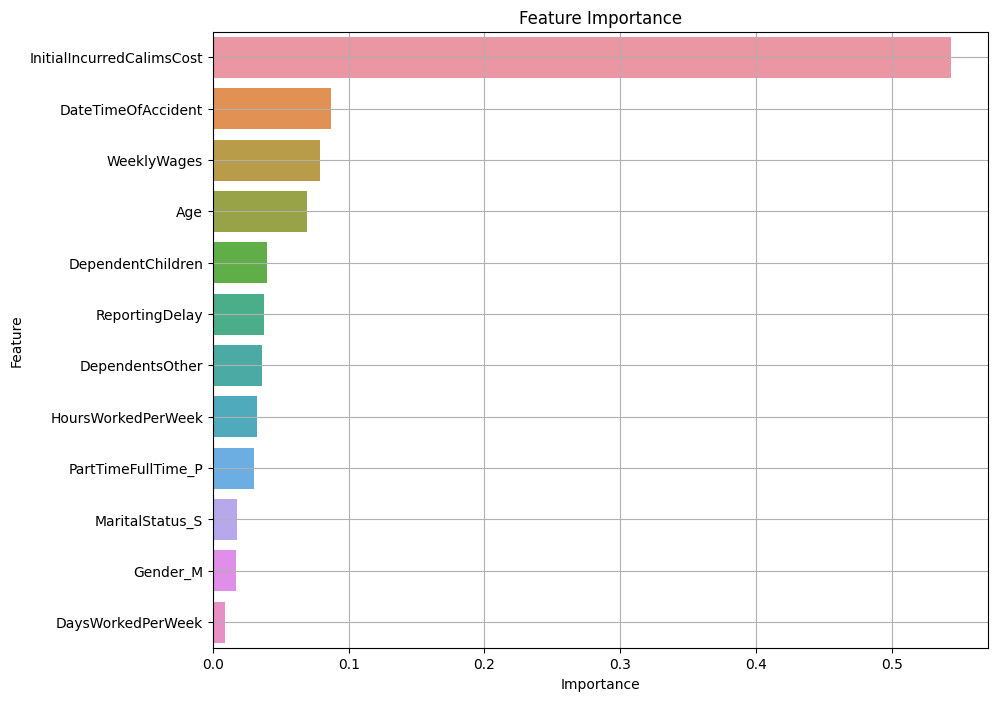

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mendapatkan feature importance dari model
feature_importance = model.feature_importances_

# Membuat dataframe dengan feature names dan importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Mengurutkan dataframe berdasarkan importance scores secara menurun
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Membuat plot bar
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

In [44]:
X.shape

(40525, 12)

In [84]:
import numpy as np

# y_1 adalah variabel target tanpa index
y_1 = y[:, 0]


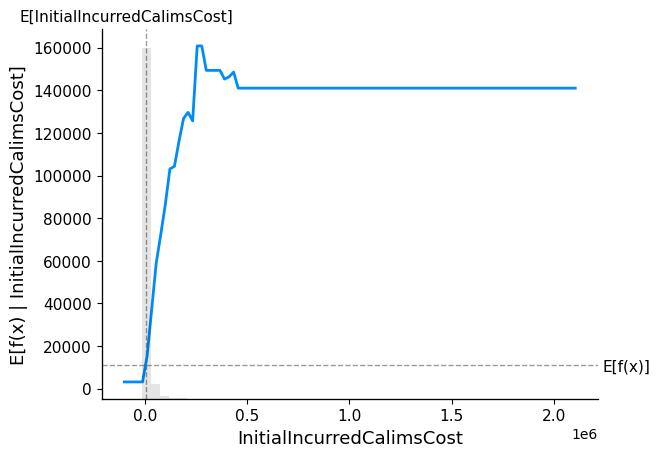

In [85]:
#  Partial Dependence Plot 1 
shap.plots.partial_dependence(
    'InitialIncurredCalimsCost', 
    model.predict, 
    X, 
    ice=False, 
    model_expected_value=True, 
    feature_expected_value=True
)


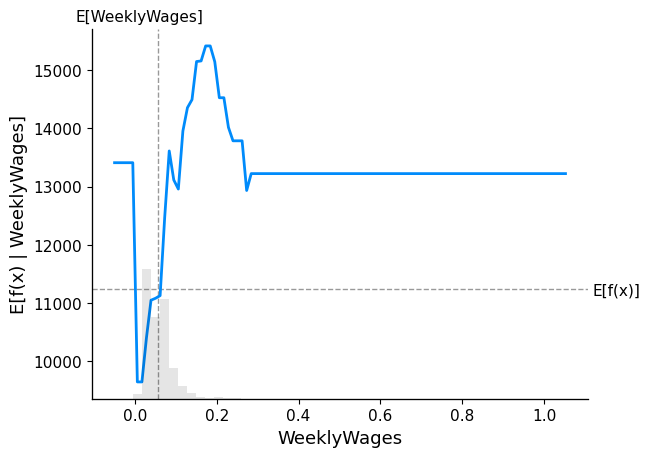

In [70]:
#  Partial Dependence Plot 2

shap.plots.partial_dependence(
    'WeeklyWages', 
    model.predict, 
    X, 
    ice=False, 
    model_expected_value=True, 
    feature_expected_value=True
)


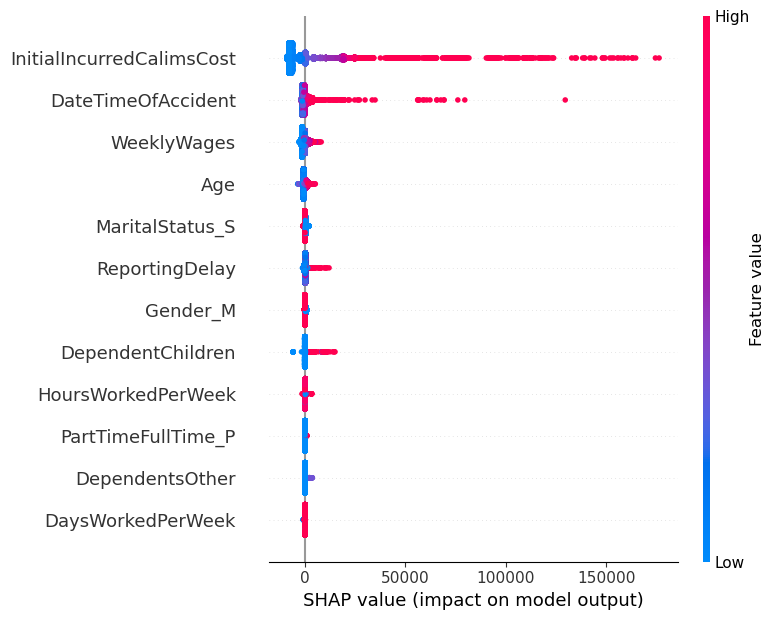

In [67]:
#SHAP 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X, check_additivity=False)
shap.summary_plot(shap_values, X)